In [1]:
import os
import warnings
from joblib import load
from utils.plot import *
from utils.scaler import *
from scipy.stats import entropy
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

In [2]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [3]:
X_test = pd.read_csv('Database/test/X_self_test_norm.csv', index_col=0)
# X_test = pd.read_csv('Database/test/X_real_test_norm.csv', index_col=0)
y_test = pd.read_csv('Database/test/y_self_test.csv', index_col=0)

# Best-model dict 저장

In [5]:
GMM_list = [i for i in range(20)]
GMM_list.remove(1)

lgb_files = sorted(filename for filename in os.listdir('File/LGBM') if filename.endswith('.pkl'))
xgb_files = sorted(filename for filename in os.listdir('File/XGB') if filename.endswith('.pkl'))
cat_files = sorted(filename for filename in os.listdir('File/CAT') if filename.endswith('.pkl'))

best_lgb_dict = {}
best_xgb_dict = {}
best_cat_dict = {}

for i, STN in enumerate(GMM_list):
    best_lgb_dict[STN] = load(os.path.join('File/LGBM', lgb_files[i]))
    best_xgb_dict[STN] = load(os.path.join('File/XGB', xgb_files[i]))
    best_cat_dict[STN] = load(os.path.join('File/CAT', cat_files[i]))

# 예측값 dict 저장

In [6]:
pred_lgb_dict = {}
pred_xgb_dict = {}
pred_cat_dict = {}

for i, STN in enumerate(GMM_list):
    pred_lgb_dict[STN] = pd.DataFrame(best_lgb_dict[STN].predict_proba(X_test))
    pred_xgb_dict[STN] = pd.DataFrame(best_xgb_dict[STN].predict_proba(X_test))
    pred_cat_dict[STN] = pd.DataFrame(best_cat_dict[STN].predict_proba(X_test))

# 60개 싱글모델 예측값 DataFrame 저장

In [7]:
prediction_list = []
for i, STN in enumerate(GMM_list):
    prediction_list.append(pred_lgb_dict[STN].values)
    prediction_list.append(pred_xgb_dict[STN].values)
    prediction_list.append(pred_cat_dict[STN].values)
    predictions = np.array(prediction_list)

In [39]:
selected_indices = [i for i in range(57)]
delete_list = [9, 11, 12, 21, 22, 27, 36, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]

selected_indices=[p for p in selected_indices if p not in delete_list]
selected_predictions = predictions[selected_indices]

# Hard Voting

In [42]:
from scipy.stats import mode

individual_predictions = np.argmax(selected_predictions, axis=2)

final_predictions, _ = mode(individual_predictions, axis=0)
final_predictions = final_predictions.ravel()
HV_pred_df = pd.DataFrame(final_predictions, index=X_test.index)

# Soft Voting

In [43]:
average_predictions = np.mean(selected_predictions, axis=0)
final_predictions = np.argmax(average_predictions, axis=1)
SV_pred_df = pd.DataFrame(final_predictions, index=X_test.index)

# Entropy Fuzzy

In [44]:
def fuzzy_ensemble_predict(predictions):
    # 엔트로피 기반 가중치 계산
    entropies = np.array([entropy(pred.T) for pred in predictions])
    weights = 1 - entropies / np.max(entropies)
    weights = weights / np.sum(weights, axis=0)

    # 가중 평균 계산
    weighted_predictions = np.zeros((predictions.shape[1], predictions.shape[2]))

    # 가중치를 적용한 최종 예측 계산
    for i in range(predictions.shape[0]):
        weighted_predictions += weights[i, :, np.newaxis] * predictions[i]
    final_predictions = np.argmax(weighted_predictions, axis=1)
    return final_predictions


ensembled_pred = fuzzy_ensemble_predict(selected_predictions)

In [45]:
EF_pred_df = pd.DataFrame(ensembled_pred, index=X_test.index)

# CSI 계산

In [46]:
# data = pd.concat([pd.DataFrame(np.argmax(predictions[28], axis=1), index=y_test.index), y_test], axis=1)
# data = pd.concat([HV_pred_df, y_test], axis=1)
# data = pd.concat([SV_pred_df, y_test], axis=1)
data = pd.concat([EF_pred_df, y_test], axis=1)
mapping = {
    0: "<0.1",
    1: "0.1<=X<0.2",
    2: "0.2<=X<0.5",
    3: "0.5<=X<1",
    4: "1<=X<2",
    5: "2<=X<5",
    6: "5<=X<10",
    7: "10<=X<20",
    8: "20<=X<30",
    9: "X>=30"
}

data['predicted'] = data.iloc[:, 0].map(mapping)
data['observed'] = data.iloc[:, 1].map(mapping)

csi_categories = ["<0.1", "0.1<=X<0.2", "0.2<=X<0.5", "0.5<=X<1", "1<=X<2", "2<=X<5", "5<=X<10", "10<=X<20", "20<=X<30",
                  "X>=30"]
csi_table = pd.DataFrame(0, index=csi_categories, columns=csi_categories)

for index, row in data.iterrows():
    observed = row['observed']
    predicted = row['predicted']
    csi_table.at[observed, predicted] += 1

cal_CSI(csi_table)

0.029045011112572787

# Real-test prediction 저장

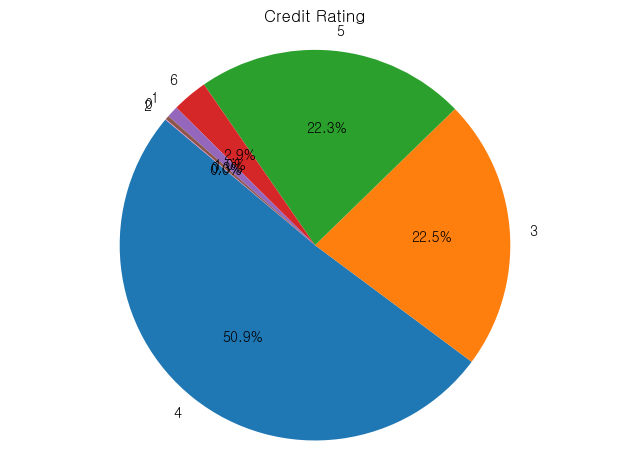

In [48]:
plot_imabalance(EF_pred_df, 0)

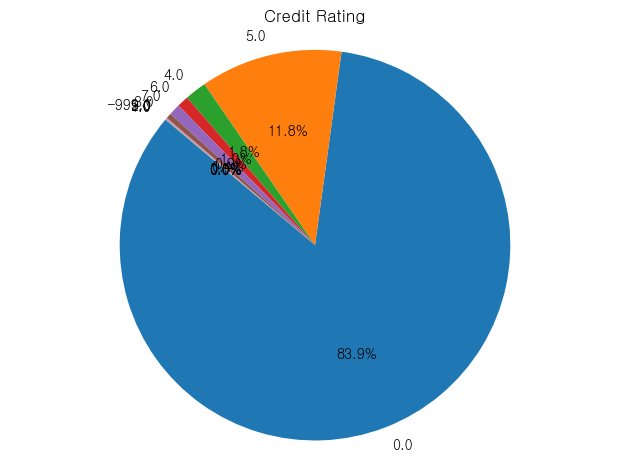

In [343]:
submssion_df = pd.read_csv('Database/rainfall_test.csv')
submssion_df.loc[EF_pred_df.index, 'rainfall_test.class_interval'] = EF_pred_df[0]
plot_imabalance(submssion_df, 'rainfall_test.class_interval')

In [344]:
submssion_df.to_csv('File/240105.csv', index=False)